# AML Homework 3: Practice


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques. 


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model. 
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F
import platform as pl


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [2]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        
        nn.Linear(32, 10)
    )
    
    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [3]:
# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
images = np.stack([train_dataset[i][0] for i in range(len(train_dataset))])

# Compute the mean and standard deviation for each channel
mean = images.mean(axis=(0, 2, 3))
std = images.std(axis=(0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  [0.4914 0.4822 0.4465]
Std:  [0.247  0.2435 0.2616]


In [4]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),          # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)  

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

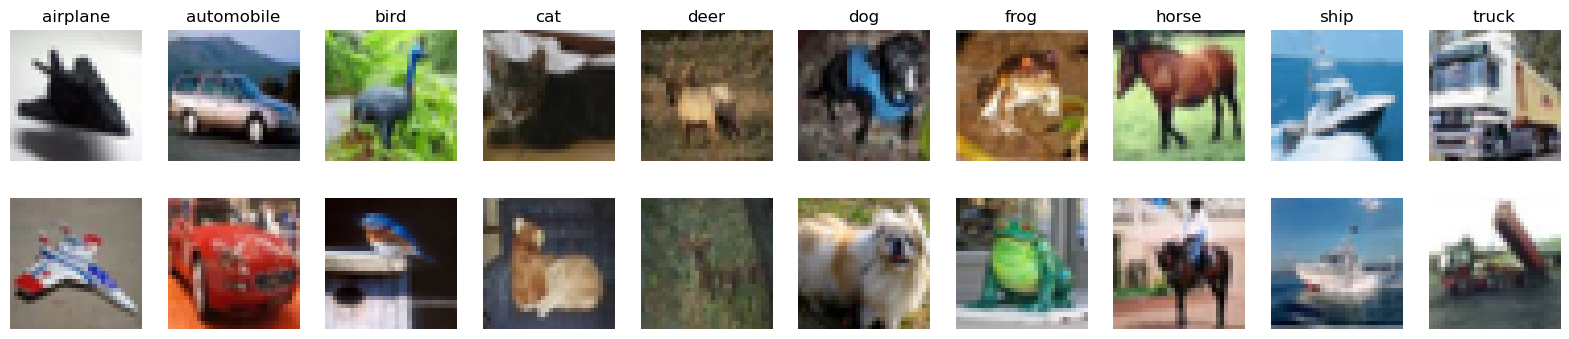

In [6]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')
    

### 1.4: Training Loop

In [7]:
# We had to add this check cause we are also using ARM systems
if pl.system() == "Darwin":
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load weights
model = create_model()
model.load_state_dict(torch.load('checkpoint/model_weights.pth', weights_only=True))  
model.to(device)

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler 
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")



Epoch [1/20]: 100%|██████████| 98/98 [00:11<00:00,  8.91it/s, loss=1.57]


Epoch [1/20], Average Loss: 1.8941
Validation Loss: 1.6080


Epoch [2/20]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.4] 


Epoch [2/20], Average Loss: 1.4628
Validation Loss: 1.3944


Epoch [3/20]: 100%|██████████| 98/98 [00:10<00:00,  9.61it/s, loss=1.29]


Epoch [3/20], Average Loss: 1.3180
Validation Loss: 1.2050


Epoch [4/20]: 100%|██████████| 98/98 [00:10<00:00,  9.59it/s, loss=1.17]


Epoch [4/20], Average Loss: 1.2498
Validation Loss: 1.2114


Epoch [5/20]: 100%|██████████| 98/98 [00:10<00:00,  9.52it/s, loss=1.18]


Epoch [5/20], Average Loss: 1.1953
Validation Loss: 1.1738


Epoch [6/20]: 100%|██████████| 98/98 [00:10<00:00,  9.51it/s, loss=1.19]


Epoch [6/20], Average Loss: 1.1558
Validation Loss: 1.1309


Epoch [7/20]: 100%|██████████| 98/98 [00:10<00:00,  9.57it/s, loss=1.15]


Epoch [7/20], Average Loss: 1.1206
Validation Loss: 1.0289


Epoch [8/20]: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s, loss=1.05]


Epoch [8/20], Average Loss: 1.0961
Validation Loss: 1.0001


Epoch [9/20]: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s, loss=1.09] 


Epoch [9/20], Average Loss: 1.0804
Validation Loss: 1.1155


Epoch [10/20]: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s, loss=1.08] 


Epoch [10/20], Average Loss: 1.0586
Validation Loss: 1.0314


Epoch [11/20]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=0.981]


Epoch [11/20], Average Loss: 1.0358
Validation Loss: 0.9611


Epoch [12/20]: 100%|██████████| 98/98 [00:10<00:00,  9.41it/s, loss=0.91] 


Epoch [12/20], Average Loss: 1.0222
Validation Loss: 0.9391


Epoch [13/20]: 100%|██████████| 98/98 [00:10<00:00,  9.53it/s, loss=1.11] 


Epoch [13/20], Average Loss: 1.0024
Validation Loss: 1.0020


Epoch [14/20]: 100%|██████████| 98/98 [00:10<00:00,  9.44it/s, loss=1.01] 


Epoch [14/20], Average Loss: 0.9978
Validation Loss: 1.0183


Epoch [15/20]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1]    


Epoch [15/20], Average Loss: 0.9728
Validation Loss: 0.8788


Epoch [16/20]: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s, loss=0.886]


Epoch [16/20], Average Loss: 0.9601
Validation Loss: 0.9412


Epoch [17/20]: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s, loss=1.07] 


Epoch [17/20], Average Loss: 0.9570
Validation Loss: 1.0149


Epoch [18/20]: 100%|██████████| 98/98 [00:10<00:00,  9.13it/s, loss=0.918]


Epoch [18/20], Average Loss: 0.9408
Validation Loss: 0.8788


Epoch [19/20]: 100%|██████████| 98/98 [00:10<00:00,  9.14it/s, loss=0.895]


Epoch [19/20], Average Loss: 0.9327
Validation Loss: 0.8700


Epoch [20/20]: 100%|██████████| 98/98 [00:11<00:00,  8.90it/s, loss=0.914]


Epoch [20/20], Average Loss: 0.9232
Validation Loss: 0.9369


Best validation loss: 0.8700


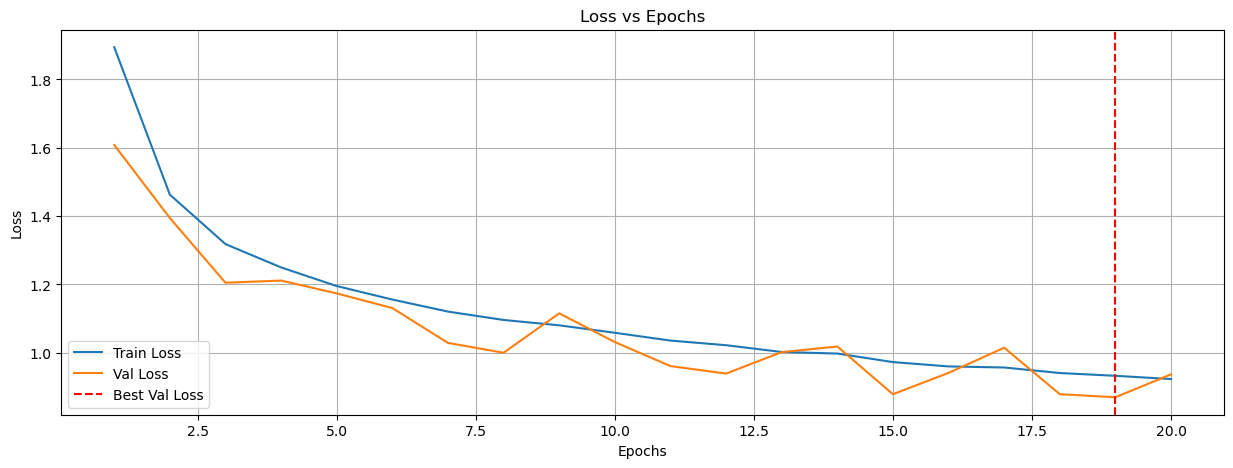

In [9]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A: it can be seen that:

1) *Loss oversizing* :  "Val Loss" oscillates and reach the minimum Loss at the 18 epoch. This could indicate that the model is starting to overfit to the training data, adapting too much to the specifich characteristics of the training set and losing its ability to generalize well on new data.

2) *Stability of Val Loss* : There is no constant variability in the Val Loss curve, that could mean:

    - The Branch Size is too small, that put high variance in the loss estimates. Increasing the batch size could stabilize the Val Loss curve

    - There a possibile noise inside the dataset

3) *Difference between train and Val Loss* : While the Train Loss has a constant decrease, the other (Val Loss) fluctuates. The Training and Val Loss should converge, but there's an increasing discrepancy.
     

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [10]:
# accuracy 
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [11]:
# your model 
model = create_model()
model.load_state_dict(torch.load('checkpoint/trained_model.pth', weights_only=True))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set 
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 70.4780
Your Model Test Accuracy : 68.9500


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [12]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth",map_location="mps", weights_only=False))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

Train accuracy: 86.3800
Test Accuracy: 80.9000


# Section 2: Unlearning 

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario, 
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned. 

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning 

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data. 
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [13]:
#train
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in train_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset = torch.utils.data.Subset(train_dataset, indices_to_remember)
forget_dataset = torch.utils.data.Subset(train_dataset, indices_to_forget)
retain_loader = DataLoader(retain_dataset, batch_size)
forget_loader = DataLoader(forget_dataset, batch_size)

In [14]:
#validation
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in val_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset_val = torch.utils.data.Subset(val_dataset, indices_to_remember)
forget_dataset_val = torch.utils.data.Subset(val_dataset, indices_to_forget)
retain_loader_val = DataLoader(retain_dataset_val, batch_size)
forget_loader_val = DataLoader(forget_dataset_val, batch_size)

In [15]:
#test 
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in test_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset_test = torch.utils.data.Subset(test_dataset, indices_to_remember)
forget_dataset_test = torch.utils.data.Subset(test_dataset, indices_to_forget)
retain_loader_test = DataLoader(retain_dataset_test, batch_size)
forget_loader_test = DataLoader(forget_dataset_test, batch_size)

### 2.2: Training Loop

In [16]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    # We had to add this check cause we are also using ARM systems
    if pl.system() == "Darwin":
      device = torch.device("mps" if torch.mps.is_available() else "cpu")
    else:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []
   
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(retain_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in retain_loader_val:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
        
                
    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [17]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth", map_location="mps", weights_only=False))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, val_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.70it/s, loss=0.471]


Epoch [1/10], Average Loss: 0.5236
Validation Loss: 0.5104


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=0.459]


Epoch [2/10], Average Loss: 0.5068
Validation Loss: 0.5119


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.14it/s, loss=0.441]


Epoch [3/10], Average Loss: 0.4968
Validation Loss: 0.5076


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=0.474]


Epoch [4/10], Average Loss: 0.4927
Validation Loss: 0.5003


Epoch [5/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=0.474]


Epoch [5/10], Average Loss: 0.4939
Validation Loss: 0.5063


Epoch [6/10]: 100%|██████████| 88/88 [00:09<00:00,  9.29it/s, loss=0.433]


Epoch [6/10], Average Loss: 0.4889
Validation Loss: 0.4992


Epoch [7/10]: 100%|██████████| 88/88 [00:09<00:00,  8.86it/s, loss=0.481]


Epoch [7/10], Average Loss: 0.4883
Validation Loss: 0.5025


Epoch [8/10]: 100%|██████████| 88/88 [00:09<00:00,  8.99it/s, loss=0.424]


Epoch [8/10], Average Loss: 0.4869
Validation Loss: 0.5047


Epoch [9/10]: 100%|██████████| 88/88 [00:10<00:00,  8.64it/s, loss=0.452]


Epoch [9/10], Average Loss: 0.4872
Validation Loss: 0.4998


Epoch [10/10]: 100%|██████████| 88/88 [00:09<00:00,  9.12it/s, loss=0.408]
/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_71007/858582591.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to

Epoch [10/10], Average Loss: 0.4850
Validation Loss: 0.5039


**Below there is the evaluation of your unlearned by fine-tuning model**

In [18]:

# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
forget_model.eval()
forget_model.to(device)

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_71007/3122407584.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("chec

Retain set Accuracy: 88.6711
Forget set Accuracy: 40.4600
Test set Accuracy: 77.9125
Test set Retain Accuracy: 82.9583
Test set Forget Accuracy: 32.5000


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A: 
The high accuracy on the retain set indicates that the model has preserved a good generalization ability on the data we are not trying to forget.
The relatively low accuracy on the forget set during training suggests that the unlearning process is working to some extent: the model has significantly reduced its ability to correctly predict the data we are trying to forget.
The accuracy on the test set indicates that the model is performing well despite unlearning the forget set. This shows that the process of forgetting certain data has not significantly degraded the model’s performance on the remaining data.
The model’s accuracy on the test set retain indicates that the model has successfully retained knowledge of the data we do not want it to forget. This means that the unlearning process has been effective in forgetting only the relevant data without significantly compromising the model's ability to generalize on the retained data.
The low accuracy on the test set forget is a positive sign for the unlearning process. Such a low accuracy suggests that the model has successfully forgotten most of the information related to the forget set, as it can no longer correctly classify those examples. This indicates that unlearning has been effective.

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [19]:
# We had to add this check cause we are also using ARM systems
if pl.system() == "Darwin":
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_71007/810956610.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpo

#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [ ]:

# Variabile per il miglior validation loss
best_loss = float('inf')

losses = []
losses_val = []

for epoch in range(num_epochs):
    gold_model.train()
    running_loss = 0
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = gold_model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        running_loss += loss.item()

        # Update progress bar
        loop.set_description(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m")
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    scheduler.step(avg_loss)
    print(f"Training loss: {avg_loss:.4f}")

    # Validation step
    gold_model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = gold_model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    losses_val.append(avg_val_loss)

    # Save best model based on validation loss
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        os.makedirs("checkpoint", exist_ok=True)
        torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        print("\033[92mBest model saved with validation loss: {:.4f}\033[0m".format(best_loss))


Epoch [1/20]: 100%|██████████| 98/98 [00:11<00:00,  8.83it/s, loss=2.17]


Training loss: 2.2336
Best model saved with validation loss: 2.1562


Epoch [2/20]: 100%|██████████| 98/98 [00:10<00:00,  9.04it/s, loss=2]   


Training loss: 2.1097
Best model saved with validation loss: 2.0267


Epoch [3/20]: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s, loss=1.89]


Training loss: 1.9774
Best model saved with validation loss: 1.8842


Epoch [4/20]: 100%|██████████| 98/98 [00:11<00:00,  8.89it/s, loss=1.79]


Training loss: 1.8455
Best model saved with validation loss: 1.7542


Epoch [5/20]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.73]


Training loss: 1.7346
Best model saved with validation loss: 1.6416


Epoch [6/20]: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s, loss=1.61]


Training loss: 1.6499
Best model saved with validation loss: 1.5572


Epoch [7/20]: 100%|██████████| 98/98 [00:10<00:00,  9.46it/s, loss=1.51]


Training loss: 1.5828
Best model saved with validation loss: 1.4959


Epoch [8/20]: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s, loss=1.46]


Training loss: 1.5286
Best model saved with validation loss: 1.4343


Epoch [9/20]: 100%|██████████| 98/98 [00:10<00:00,  9.45it/s, loss=1.45]


Training loss: 1.4781
Best model saved with validation loss: 1.3947


Epoch [10/20]: 100%|██████████| 98/98 [00:10<00:00,  9.41it/s, loss=1.39]


Training loss: 1.4419
Best model saved with validation loss: 1.3417


Epoch [11/20]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=1.46]


Training loss: 1.4040
Best model saved with validation loss: 1.3131


Epoch [12/20]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=1.38]


Training loss: 1.3739
Best model saved with validation loss: 1.2816


Epoch [13/20]: 100%|██████████| 98/98 [00:10<00:00,  9.30it/s, loss=1.32]


Training loss: 1.3486
Best model saved with validation loss: 1.2535


Epoch [14/20]: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s, loss=1.35]


Training loss: 1.3288
Best model saved with validation loss: 1.2435


Epoch [15/20]:  18%|█▊        | 18/98 [00:01<00:08,  9.37it/s, loss=1.29]

In [ ]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [ ]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device)

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: The Gold Model shows a constant improvement, with a less loss during the training and saving a checkpoint when it reaches its best perfomance.
After the checkpoint load, the model has an greater accuracy  on *retain* set than *forget*. This difference is expected, as the model is designed to keep the important information of the
*retain* set and selectively disregard that of the *forget* one.
In this way, it shows that it can effectively differentiate between the two types of data.

# Section 4: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [ ]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """
    # We had to add this check cause we are also using ARM systems
    if pl.system() == "Darwin":
        device = torch.device("mps" if torch.mps.is_available() else "cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()
   
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


In [ ]:
#model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth",map_location="mps"));
model.eval()
model.to(device)

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)


In [ ]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device)

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)


In [ ]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));
gold_model.eval()
gold_model.to(device)

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

In [ ]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """
    
    torch.manual_seed(torch.initial_seed())
    
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )
    
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy", 
    )

In [ ]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

In [ ]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

In [ ]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A: 
- **Model**:
The loss distributions between the *Retain* and *Forget* samples are very similar, in the plots. 
That can be considered in a low MIA score, indicating that the model does not expose much information about whether the data was used for training. Therefore, it is difficult for the attacker to discriminate samples on the basis of membership.

- **Forget Model**:
The loss for the *Forget* samples are higher, andthe loss distributions between *Retain* and *Forget* are well separated.
This leads to a higher MIA score, suggesting that this model is vulnerable to MIA attack, as the attacker is bettere able to identify the sample belonging to the training set.

- **Gold Model**:
Losses are balanced between the *Retain* and *Forget* samples. This model has low MIA score, indicating that it is well generalised and withstands the MIA attack, thus protecting the training data.


# 5. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point) 

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: In this case, KL divergence is preferred over Cross-Entropy because it measures how much the predicted distribution deviates from the target (uniform) distribution. Since we want the model to forget by making its predictions match a uniform distribution, KL divergence directly quantifies the distance from this ideal distribution, while Cross-Entropy assumes a specific ground-truth class, which is not applicable here.

In [ ]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])  
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''
cross_entropy = F.cross_entropy(y_pred.unsqueeze(0), y_gt.argmax().unsqueeze(0))
kl_div = F.kl_div(y_pred.log(), y_gt, reduction="sum")

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A: 

**Cross-Entropy** measures the difference between two probability distributions for a given set of events outcomes. For two distributions (**P**) (true distribution) and (**Q**) (approx distribution), the cross-entropy is defined as:

$$ H(P, Q) = - \sum_x P(x) \log Q(x) $$


**Kullback-Leibler (KL)** Divergence, measures how one probability distribution diverges from a second, expected probability distribution. For distribution (**P**) and (**Q**), the KL is:

$$ D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)} $$



**Relationship between Cross-Entropy and KL Divergence** can be derived as follows:

1. Start with the definition of KL Divergence and rewrite the logarithm term:

   $$ D_{KL}(P \| Q) = \sum_x P(x) \log P(x) - \sum_x P(x) \log Q(x) $$

2. Recognize that the first term is the negative entropy of (**P**):

   $$ H(P) = - \sum_x P(x) \log P(x) $$

   Therefore,

   $$ -H(P) = \sum_x P(x) \log P(x) $$

3. Substitute this into the KL Divergence equation:

   $$ D_{KL}(P \| Q) = -H(P) + \sum_x P(x) \log Q(x) $$

4. Notice that the second term is the negative cross-entropy:

   $$ H(P, Q) = - \sum_x P(x) \log Q(x) $$

   Therefore

   $$ -H(P, Q) = \sum_x P(x) \log Q(x) $$

5. Combine these results:

   $$ D_{KL}(P \| Q) = -H(P) - H(P, Q) $$

   Rearranging gives us:

   $$ H(P, Q) = H(P) + D_{KL}(P \| Q) $$

The cross-entropy (**H(P, Q)**) between two distributions (**P**) and (**Q**) is equal to the entropy (**H(P)**) of the true distribution plus the KL divergence (D_{KL}**(P | Q)**) between the true distribution and the approximate distribution. This relationship shows that cross-entropy includes both the inherent uncertainty in the true distribution and the additional uncertainty due to the approximation.



In [ ]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0
    
    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [ ]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []
    
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)
            
            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [ ]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth", map_location="mps"));
another_forget_model.to(device)

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

In [ ]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
# calculate accuracy 
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

In [ ]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

In [ ]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

In [ ]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [ ]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

In [ ]:
# Convert our model to graph

from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("checkpoint/best_model.pth", map_location="mps")
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

# GMN Dataset Building

Now we are gonna create a small CNN, we'll train it and then we will convert it into a graph.

For the CNNs we'll use the same structure defined in the first section of this notebook.

In [ ]:

def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        
        nn.Linear(32, 10)
    )
    
    return model

In [ ]:
# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
images = np.stack([train_dataset[i][0] for i in range(len(train_dataset))])

# Compute the mean and standard deviation for each channel
mean = images.mean(axis=(0, 2, 3))
std = images.std(axis=(0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),          # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)  

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

In [ ]:
# We had to add this check cause we are also using ARM systems
if pl.system() == "Darwin":
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load weights
models = []
for _ in range(128):
    model = create_model()
    model.load_state_dict(torch.load('checkpoint/model_weights.pth', weights_only=True))  
    model.to(device)
    models.append(model)

# initialize the loss function
criterion = nn.CrossEntropyLoss()


In [ ]:
import random

count = 0

for model in models:
    # define random optimizers for training
    optimizers = optimizers = [
    torch.optim.Adam(model.parameters(), lr=0.001),
    torch.optim.Adam(model.parameters(), lr=0.005),
    torch.optim.Adam(model.parameters(), lr=0.0001),
    torch.optim.SGD(model.parameters(), lr=0.001),
    torch.optim.RMSprop(model.parameters(), lr=0.001)
]
    
    optimizer = random.choice(optimizers)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    num_epochs = random.randint(1, 4)

    # Placeholder for storing losses for each epoch
    losses = []
    losses_val = []

    # Training the model
    for epoch in range(num_epochs):

        ######### TRAINING ##########
        model.train()
        running_loss = 0  # To track loss for this epoch

        # Using tqdm for the progress bar
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    
        
        for batch_idx, (data, targets) in loop:
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient descent step
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Update progress bar with loss and epoch information
            loop.set_description(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m")
            loop.set_postfix(loss=loss.item())

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        #scheduler 
        scheduler.step(avg_loss)

        # Print loss for this epoch
        tqdm.write(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m, Average Loss: {avg_loss:.4f}")

        ####### VALIDATION ########
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                val_loss += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = val_loss / len(val_loader)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint/gmn_dataset", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/gmn_dataset/trained_model_"+str(count)+".pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/gmn_dataset/trained_model"+str(count)+".pth")
    count += 1



# Convert our models into graphs and then save the dataset

In [ ]:
# Convert our model to graph

from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(0)

gmn_dataset = []

for i in range(len(models)):

    weights = torch.load("checkpoint/gmn_dataset/trained_model_"+str(i)+".pth", map_location="mps")
    model = create_model()
    model.load_state_dict(weights)
    arch = sequential_to_arch(model)
    x, edge_index, edge_attr = arch_to_graph(arch)
    x = x.float()
    edge_attr = edge_attr.float()

    # currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
    g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

    graph_batch = Batch.from_data_list([g_cnn])
    print(graph_batch)

    gmn_dataset.append(graph_batch) # store it

# TODO: convertire in dataset
torch_dataset = gmn_dataset

dataloader = DataLoader(torch_dataset, batch_size=32, shuffle=True)

for batch in dataloader:
    print(batch)


    

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

In [ ]:
'''
Add your code below
'''
import collections


if isinstance(weights, collections.OrderedDict):
    weights = torch.cat([v.flatten() for v in weights.values()])


arch_new = graph_to_arch(arch, weights)

layers = []

for layer_info in arch_new:
    layer_type = layer_info[0]
    if layer_type == nn.Linear:
        out_features, in_features = layer_info[1].shape
        layers.append(nn.Linear(in_features, out_features))
    elif layer_type == nn.Conv2d:
        out_channels, in_channels, kernel_height, kernel_width = layer_info[1].shape
        layers.append(nn.Conv2d(in_channels, out_channels, (kernel_height, kernel_width)))
    elif layer_type == nn.BatchNorm2d:
        num_features = layer_info[1].shape[0]
        layers.append(nn.BatchNorm2d(num_features))
        

model = nn.Sequential(*layers)

model = arch_to_sequential(arch_new, model)

print(model)

## Report

...